# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This project is to build a classification system of traffic signs, based on the training data from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The classification accuracy of humans on this dataset is ~98%. Can my model match/beat the human accuracy? 

The main stages are: 
- dataset exploration
- data augmentation
- model architecture experiments
- testing on images 'from the wild'

---
### Preparatory steps: import packages, load data

In [1]:
import pickle
import numpy as np
import pandas as pd
import cv2

In [2]:
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, concatenate, Input
from keras import utils
from keras.callbacks import Callback, LambdaCallback, EarlyStopping, ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Adam
from keras import backend as K
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [3]:
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style("whitegrid")

In [4]:
# Load pickled data

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [5]:
# number of training images
n_train = X_train.shape[0]

# number of validation images
n_validation = X_valid.shape[0]

# number of testing iamges
n_test = X_test.shape[0]

# shape of an traffic sign image
image_shape = [X_train.shape[1], X_train.shape[2], X_train.shape[3] ]

# number of unique classes/labels in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


In [ ]:
# also convert labels to one hot categorical for training
y_train_cat = utils.to_categorical(y_train, n_classes)
y_valid_cat = utils.to_categorical(y_valid, n_classes)
y_test_cat = utils.to_categorical(y_test, n_classes)

np.save('data/y_train_cat.npy', y_train_cat)
np.save('data/y_valid_cat.npy', y_valid_cat)
np.save('data/y_ttest_cat.npy', y_test_cat)

### Dataset visualisation/exploration
Let's look at the dataset to see if there are any potential issues with the images that I need to be aware of:

In [7]:
# read in the signnames reference so I know what the class numbers actually refer to
signnamesDF = pd.read_csv('./signnames.csv')
signnamesDF.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


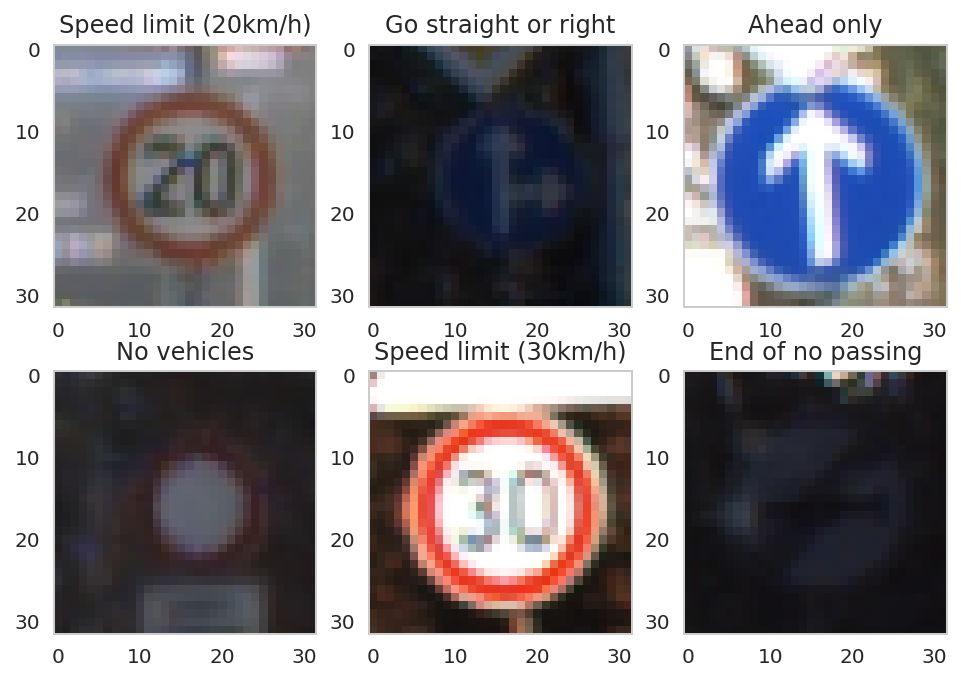

In [8]:
# let's have a look at a few different image to see what they're like
ax = plt.subplot(2,3,1)
ax.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[10000]]['SignName'][y_train[10000]])
ax.grid(False)
ax.imshow(X_train[10000])
ax2 = plt.subplot(2,3,2)
ax2.grid(False)
ax2.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[1000]]['SignName'][y_train[1000]])
ax2.imshow(X_train[1000])
ax3 = plt.subplot(2,3,3)
ax3.grid(False)
ax3.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[20000]]['SignName'][y_train[20000]])
ax3.imshow(X_train[20000])

ax4 = plt.subplot(2,3,4)
ax4.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[30000]]['SignName'][y_train[30000]])
ax4.grid(False)
ax4.imshow(X_train[30000])
ax5 = plt.subplot(2,3,5)
ax5.grid(False)
ax5.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[3000]]['SignName'][y_train[3000]])
ax5.imshow(X_train[3000])
ax6 = plt.subplot(2,3,6)
ax6.grid(False)
ax6.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[200]]['SignName'][y_train[200]])
ax6.imshow(X_train[200])

plt.savefig('examples/train_examples.jpg')

One immediate observation is that the images vary quite a bit in terms of how bright they are-- this is likely to cause issues in training. Image normalisatin is likely to help here, together with histogram equalisation to increase contrast. (to be implemented in the image preprocessing pipelin)

#### Class distribution
it would be useful to see if there are any imbalances in the classes, as these can 
affect accuracy of the training, especially if the validation/test distributions are quite different

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


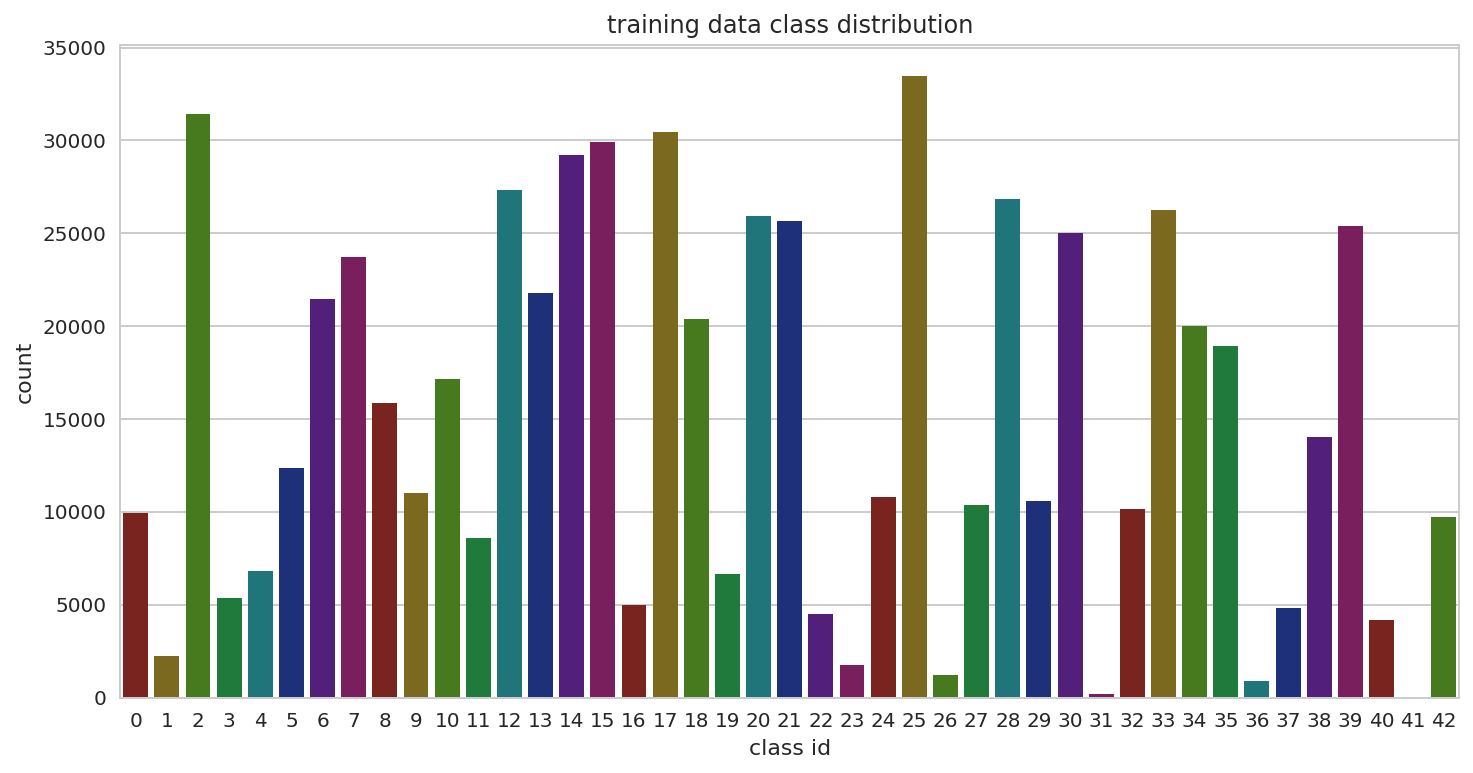

In [13]:
train_class_id, train_class_count = np.unique(y_train, return_index=True)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = sns.barplot(train_class_id, train_class_count, palette=sns.hls_palette(8, l=.3, s=.8))
ax.set(xlabel='class id', ylabel='count', title="training data class distribution")
plt.savefig('examples/train_distribution.jpg')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


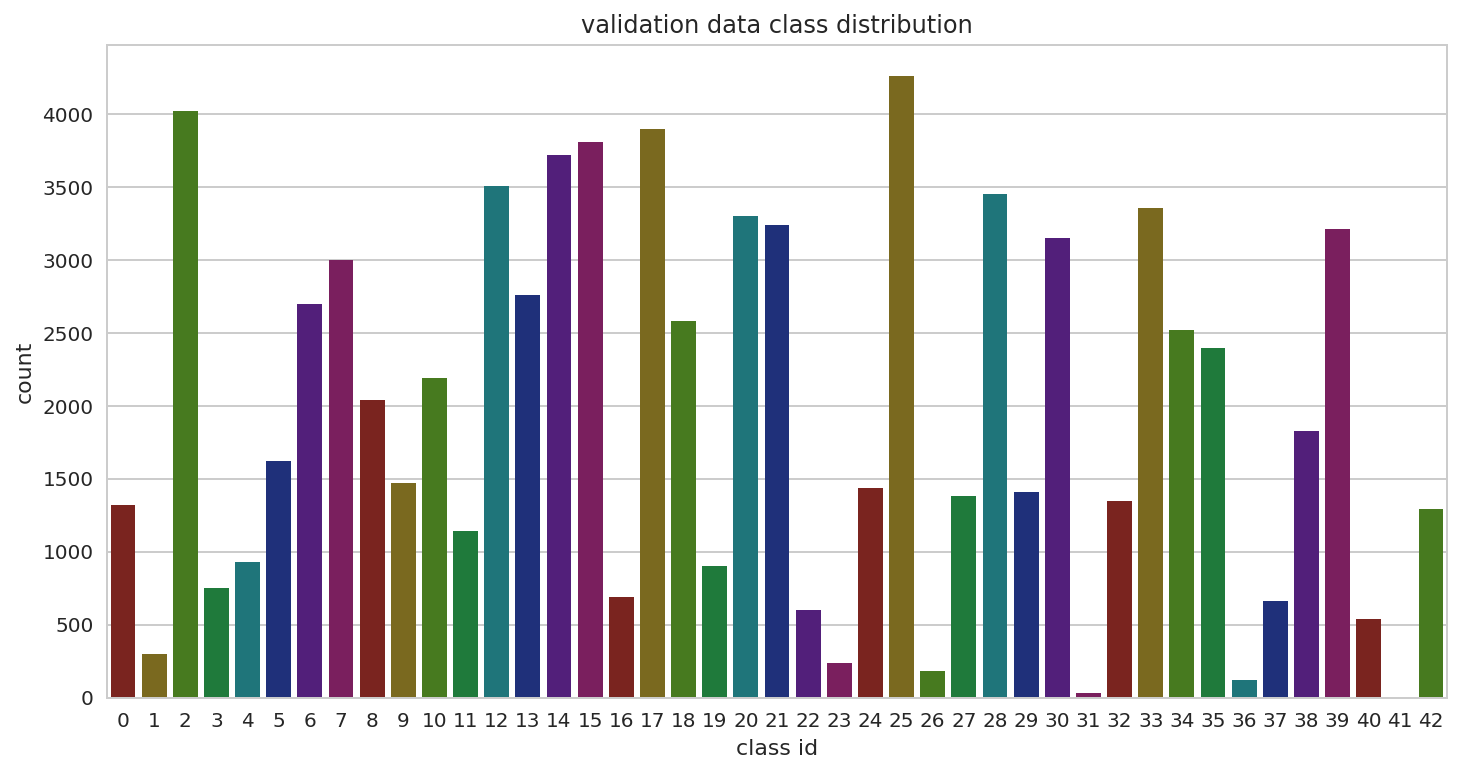

In [14]:
valid_class_id, valid_class_count = np.unique(y_valid, return_index=True)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = sns.barplot(valid_class_id, valid_class_count, palette=sns.hls_palette(8, l=.3, s=.8))
ax.set(xlabel='class id', ylabel='count', title="validation data class distribution")
plt.savefig('examples/validation_distribution.jpg')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


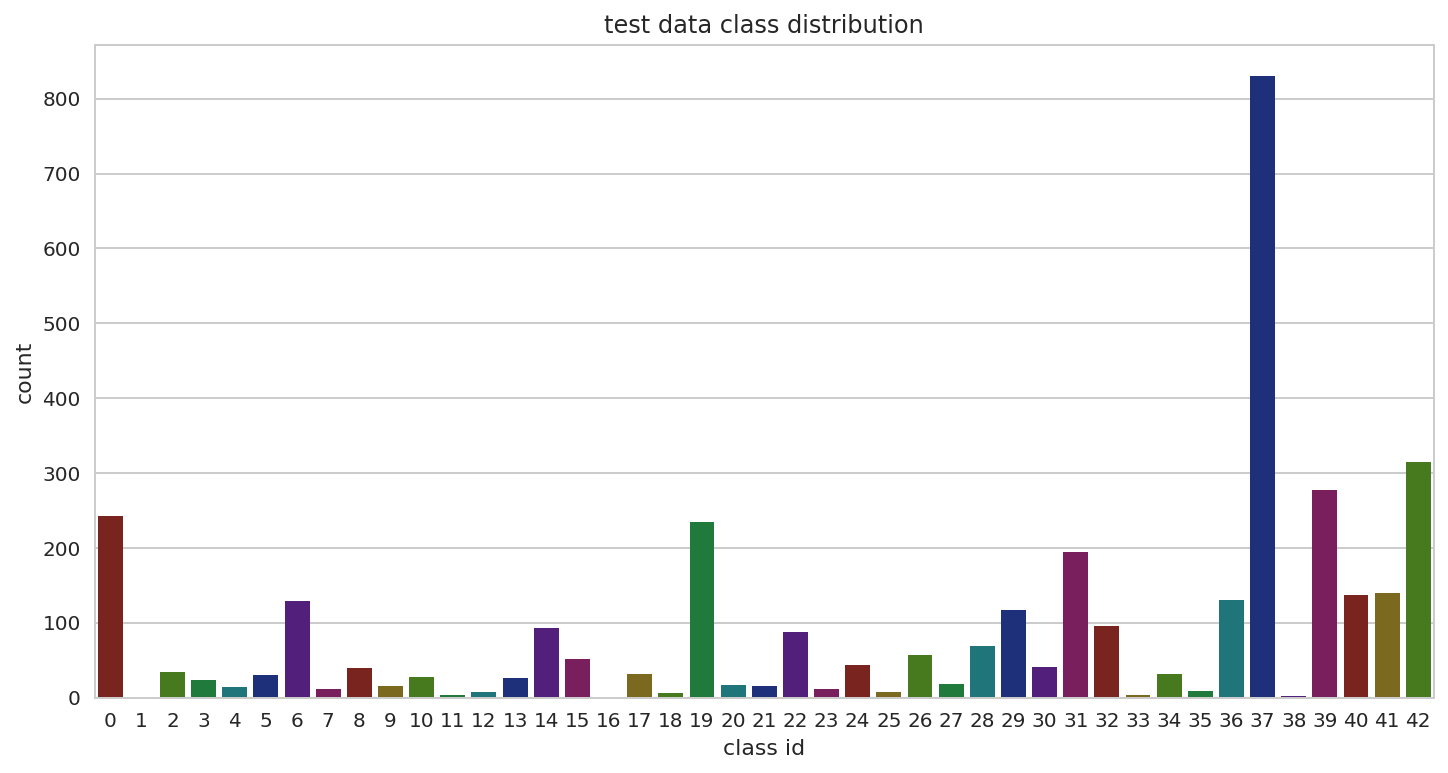

In [15]:
test_class_id, test_class_count = np.unique(y_test, return_index=True)
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax = sns.barplot(test_class_id, test_class_count, palette=sns.hls_palette(8, l=.3, s=.8))
ax.set(xlabel='class id', ylabel='count', title="test data class distribution")
plt.savefig('examples/test_distribution.jpg')

From the above 3 plots, the classes are not very balanced, perhaps reflecting the reality of how common each type of sign there is 'in the wild'. 

The class inbalance could be addressed by weighting in calculating the loss function (e.g. by using the class_weight param in keras) or using image augmentation to generate 'fake' images

The test data has a different distribution to the train/validation data. However, if the model is well generalised this shouldn't be an issue

---
### Step 2: Image preprocessing

The steps are:
1. histogram normalisation: this is done by converting to YUV color channel and normalising the Y (brightness) channel, which leaving the U and V channels which corresponds to color unchanged.
2. normalised the images 
3. Augment data with rotated, shifted, zoomed images using the ImageDataGenerator from keras

In [19]:
def histogramEqualisation(img):
    original_type = img.dtype
    if img.dtype != 'uint8':
        img = img.astype('uint8')
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    equalised = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return equalised.astype(original_type)


def hist(X):
    out = []
    for i in range(len(X)):
        out.append(histogramEqualisation(X[i]))
    return np.array(out)

def normalise(x, min_x, max_x):
    return (x - min_x) / (max_x - min_x)

In [17]:
# historgram equalised
X_train_histogram =  hist(X_train)
X_valid_histogram = hist(X_valid)
X_test_histogram =  hist(X_test)

After histogram equalisation, the images have similar brightness, and also appear a bit 'sharper'

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


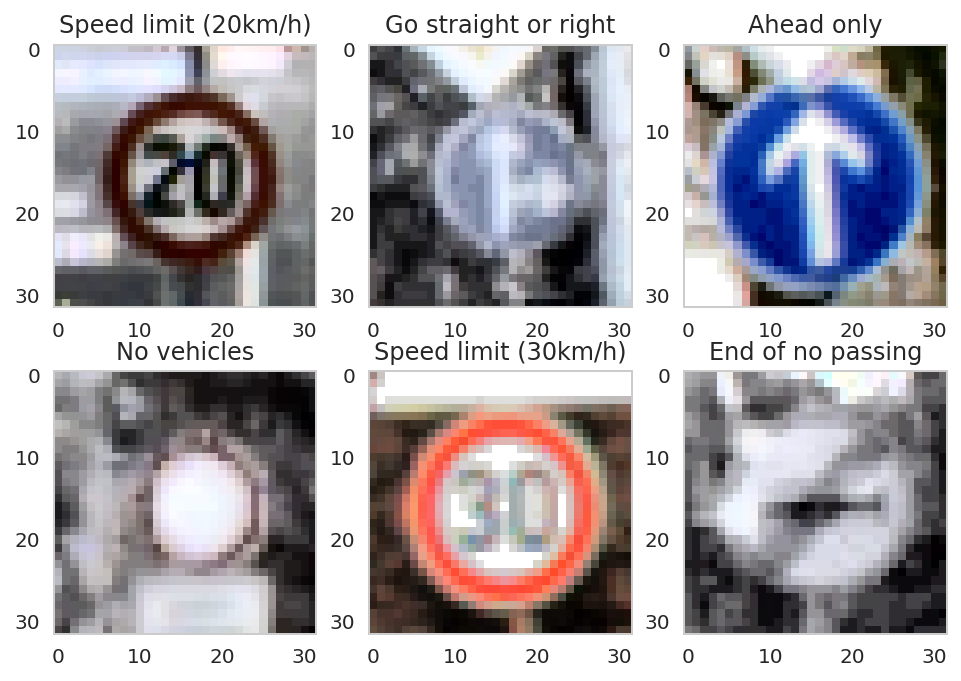

In [18]:
ax = plt.subplot(2,3,1)
ax.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[10000]]['SignName'][y_train[10000]])
ax.grid(False)
ax.imshow(X_train_histogram[10000])
ax2 = plt.subplot(2,3,2)
ax2.grid(False)
ax2.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[1000]]['SignName'][y_train[1000]])
ax2.imshow(X_train_histogram[1000])
ax3 = plt.subplot(2,3,3)
ax3.grid(False)
ax3.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[20000]]['SignName'][y_train[20000]])
ax3.imshow(X_train_histogram[20000])

ax4 = plt.subplot(2,3,4)
ax4.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[30000]]['SignName'][y_train[30000]])
ax4.grid(False)
ax4.imshow(X_train_histogram[30000])
ax5 = plt.subplot(2,3,5)
ax5.grid(False)
ax5.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[3000]]['SignName'][y_train[3000]])
ax5.imshow(X_train_histogram[3000])
ax6 = plt.subplot(2,3,6)
ax6.grid(False)
ax6.set_title(signnamesDF[signnamesDF['ClassId'] == y_train[200]]['SignName'][y_train[200]])
ax6.imshow(X_train_histogram[200])

plt.savefig('examples/train_histo_equalised_examples.jpg')

In [ ]:
mean_hist_train = np.mean(X_train_histogram)
std_hist_train = np.std(X_train_histogram)
min_hist_train = np.min(X_train_histogram)
max_hist_train = np.max(X_train_histogram)

In [ ]:
mean_hist_values = {
    'mean_hist_train': mean_hist_train,
    'std_hist_train': std_hist_train,
    'min_hist_train': min_hist_train,
    'max_hist_train': max_hist_train
}
np.save("data/mean_hist_values.npy", mean_hist_values)

In [ ]:
# normalised

X_train_hist_norm1 = normalise(X_train_histogram)
X_valid_hist_norm1 = normalise(X_valid_histogram)
X_test_hist_norm1 = normalise(X_test_histogram)

np.save('data/X_train_hist_norm1.npy', X_train_hist_norm1)
np.save('data/X_valid_hist_norm1.npy', X_valid_hist_norm1)
np.save('data/X_test_hist_norm1.npy', X_test_hist_norm1)

In [20]:
# data generator:
datagen = image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10.)

----

## Step 3:  Model Architectures


In [21]:
X_train_hist_norm1 =np.load('data/X_train_hist_norm1.npy')
X_valid_hist_norm1 =np.load('data/X_valid_hist_norm1.npy')
X_test_hist_norm1 = np.load('data/X_test_hist_norm1.npy')

y_train_cat =np.load('data/y_train_cat.npy')
y_valid_cat =np.load('data/y_valid_cat.npy')
y_test_cat = np.load('data/y_ttest_cat.npy')

In [23]:
# also define custom keras callback as verbose = 1 crashed the browser
def logger(epoch, logs):
    if epoch %1== 0: 
        print(epoch, logs['loss'], logs['acc'], logs['val_acc'])
logging_callback = LambdaCallback(
    on_epoch_end=logger)


In [22]:
# first, a quick implementation of a simple leNet to act as benchmark
# making use of the Xavier weight activation
def leNet():
    input_shape = image_shape
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape) )
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape) )
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
    return model


### TODO resume writeup from below

In [13]:
#in this run, not using the class weighting
batch_size = 32
epochs = 40
leNet_model = leNet()
leNet_model.fit(X_train_norm, y_train_cat, batch_size=batch_size,
              epochs=epochs, verbose=0,shuffle=True, validation_data=(X_valid_norm, y_valid_cat))

In [14]:
#score[0] == loss, score[1] == accuracy
score = leNet_model.evaluate(X_valid_norm, y_valid_cat, verbose=0)
print(score)

[0.92650105693020157, 0.85419501171631063]


In [ ]:
leNet_model.save('models/lenet.h5')

In [69]:

K.clear_session()
batch_size = 32
epochs = 50
leNet_model_weighted = leNet()
leNetWeightedHistory = leNet_model_weighted.fit(X_train_norm2, y_train_cat, batch_size=batch_size,
              epochs=epochs, verbose=0,shuffle=True, validation_data=(X_valid_norm2, y_valid_cat), 
                class_weight=class_weight_dict, callbacks=[logging_callback])

0 2.67188341518 0.242363286307 0.475283446793
10 0.109499424803 0.961406936981 0.922902494547
20 0.0413233256887 0.986580074167 0.93877551042
30 0.0220684893788 0.992815885514 0.944217687075
40 0.0130631612154 0.994741228196 0.938321995465


In [70]:
leNet_model_weighted.save('models/lenet_weighted.h5')

In [74]:
lenet_val_loss = leNetWeightedHistory.history.get('val_loss')
lenet_val_acc = leNetWeightedHistory.history.get('val_acc')
lenet_loss = leNetWeightedHistory.history.get('loss')
lenet_acc = leNetWeightedHistory.history.get('acc')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


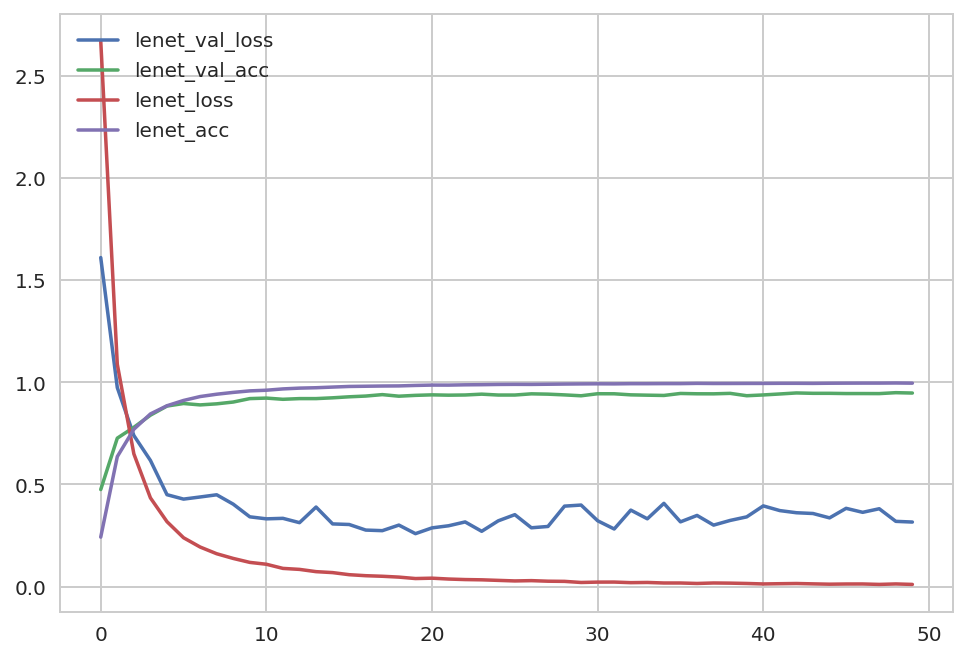

In [79]:
plt.plot(lenet_val_loss)
plt.plot(lenet_val_acc)
plt.plot(lenet_loss)
plt.plot(lenet_acc)
plt.legend(['lenet_val_loss', 'lenet_val_acc', 'lenet_loss', 'lenet_acc'], loc='upper left')
plt.show()

Just by taking into account the class imbalace, and using a better normalisation, takes the accuracy of the lenet architecture to accuracy > 93%. But can we do better than this, e.g. use a deeper network?

In [17]:
def getAugmentedImages(img):
    augmented = []
    i = 0
    for batch in datagen.flow(X_train[0:10],y_train[0:10], batch_size=1):
        augmented.append(batch)
        i += 1
        if i > 10:
            break 
            
        # otherwise the generator would loop indefinitely
# batch_size = 32
# epochs = 60
# datagen.fit(X_train)
# leNet_model.fit_generator(datagen.flow(X_train, y_train_cat, batch_size=batch_size),
#                     steps_per_epoch=len(X_train) / 32, epochs=epochs, verbose=0,
#           validation_data=(X_valid, y_valid_cat), class_weight=class_weight)


In [80]:
def model2(): #taking my inspiration from vgg, a deeper network
    input_shape = image_shape
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2,2), activation='relu', padding='same', name='set1_conv1',input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(2,2), activation='relu', padding='same', name='set1_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1_pool'))
    
    model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='same', name='set2_conv1'))
    model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='same', name='set2_conv2'))
    model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='same', name='set2_conv3'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name='set2_pool'))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', name='fc1'))
    model.add(Dense(84, activation='relu' , name='fc2'))
    model.add(Dense(n_classes, activation='softmax', name='final'))
    model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
    return model

In [23]:

batch_size = 32
epochs = 50
model2_trial1 = model2()
model2_trial1.fit(X_train_norm, y_train_cat, batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_valid_norm, y_valid_cat))

In [44]:
score2 = model2_trial1.evaluate(X_valid_norm, y_valid_cat, verbose=1)
print(model2_trial1.metrics_names, score2)

4224/4410 [===========================>..] - ETA: 0s   ['loss', 'acc'] [0.83607698960146815, 0.91836734712799661]


In [26]:
model2_trial1.save('models/model2vgg.h5')

In [39]:
model2_trial1 = load_model('models/model2vgg.h5')

In [85]:
# here, trying out model 2 with class weighting, also early stopping once the accuracy ins't chaning anymore
stopping_callback = EarlyStopping(monitor='val_acc', min_delta= 0.001, patience=5)
K.clear_session()
batch_size = 32
epochs = 80
model2_weighted = model2()
model2WeightedHistory = model2_weighted.fit(X_train_norm2, y_train_cat, batch_size=batch_size,
              epochs=epochs, verbose=0,shuffle=True, validation_data=(X_valid_norm2, y_valid_cat), 
                class_weight=class_weight_dict, callbacks=[logging_callback, stopping_callback])

0 1.73495905166 0.463605276045 0.726757369858
10 0.0199800084703 0.993563033421 0.946258503591


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


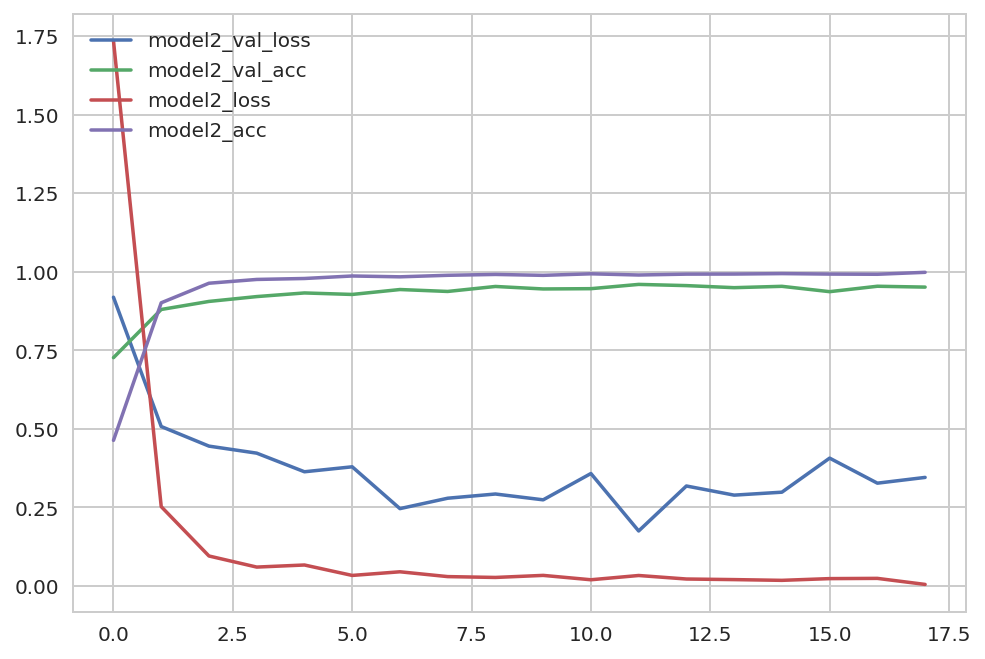

In [89]:
model2weighted_val_loss = model2WeightedHistory.history.get('val_loss')
model2weighted_val_acc = model2WeightedHistory.history.get('val_acc')
model2weighted_loss = model2WeightedHistory.history.get('loss')
model2weighted_acc = model2WeightedHistory.history.get('acc')
plt.plot(model2weighted_val_loss)
plt.plot(model2weighted_val_acc)
plt.plot(model2weighted_loss)
plt.plot(model2weighted_acc)
plt.legend(['model2_val_loss', 'model2_val_acc', 'model2_loss', 'model2_acc'], loc='upper left')
plt.show()

In [88]:
model2_weighted.save('models/model2weighted.h5')

From the above graph, it seems like the validation accuracy is going up a bit again while the train accuracy has pretty much gone to zero-- possibly overfitting? try again with a dropout layer

In [9]:
def vggLike(ksize=(3,3), dropout=0.25): #taking my inspiration from vgg, a deeper network
    input_shape = image_shape
    model = Sequential()
    model.add(Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv1',input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1_pool'))
    
    model.add(Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv1'))
    model.add(Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv2'))
    model.add(Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv3'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name='set2_pool'))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', name='fc1'))
    model.add(Dropout(dropout))
    model.add(Dense(84, activation='relu' , name='fc2'))
    model.add(Dense(n_classes, activation='softmax', name='final'))
    model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
    return model

In [92]:
# adding in dropout, plus weaking kerne size==> thiws takes the accuracy and the validation accuracy to ~ 97% 
stopping_callback2 = EarlyStopping(monitor='val_loss', min_delta= 0.00001, patience=5)
K.clear_session()
batch_size = 32
epochs = 80
vgglike = vggLike(ksize=(3,3))
vgglikeHistory = vgglike.fit(X_train_norm2, y_train_cat, batch_size=batch_size,
              epochs=epochs, verbose=0,shuffle=True, validation_data=(X_valid_norm2, y_valid_cat), 
                class_weight=class_weight_dict, callbacks=[logging_callback, stopping_callback2])

0 2.53062520356 0.262421333957 0.741043084116
10 0.0536368167726 0.98140751171 0.975510204082
20 0.0497199845252 0.986062817897 0.973242630602


In [94]:
vgglike.save('models/vggLike.h5')

In [96]:
vggLikescore = vgglike.evaluate(X_valid_norm2, y_valid_cat, verbose=0)
print('loss: ', vggLikescore[0], ' acc: ', vggLikescore[1])

loss:  0.211733393888  acc:  0.965079365458


In [100]:
#despite having a different distribution, the test accuracy is similar to validation accuracy, at 96%
vggLikescoreTest = vgglike.evaluate(X_test_norm2, y_test_cat, verbose=0)
print('loss: ', vggLikescoreTest[0], ' acc: ', vggLikescoreTest[1])

loss:  0.24570643928  acc:  0.957244655629


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [10]:
stopping_callback2 = EarlyStopping(monitor='val_loss', min_delta= 0.00001, patience=5)
# only logs every 10 epcoh
def logger(epoch, logs):
    if epoch %10== 0: 
        print(epoch, logs['loss'], logs['acc'], logs['val_acc'])
logging_callback = LambdaCallback(
    on_epoch_end=logger)


In [13]:
K.clear_session()
batch_size = 32
epochs = 80
vgglike2 = vggLike(ksize=(3,3))
vgglike2History = vgglike2.fit(X_train_norm2, y_train_cat, batch_size=batch_size,
              epochs=epochs, verbose=0,shuffle=True, validation_data=(X_valid_norm2, y_valid_cat), 
                class_weight=class_weight_dict, callbacks=[logging_callback, stopping_callback2])

0 1.85485209021 0.431966435846 0.811791383544
10 0.0577763802025 0.983131699187 0.975510204082


In [14]:
#despite having a different distribution, the test accuracy is similar to validation accuracy, at 96%
vggLike2scoreTest = vgglike2.evaluate(X_test_norm2, y_test_cat, verbose=0)
print('loss: ', vggLike2scoreTest[0], ' acc: ', vggLike2scoreTest[1])

loss:  0.216378140056  acc:  0.962866191683


In [15]:
vgglike2.save('models/vggLike2.h5')

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


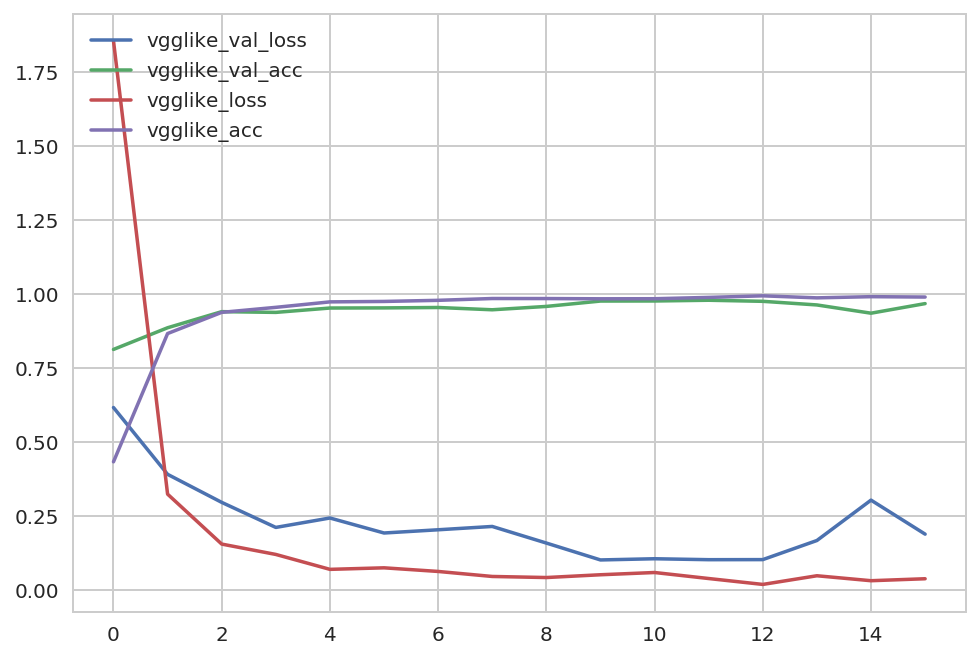

In [32]:
vgglike2weighted_val_loss = vgglike2History.history.get('val_loss')
vgglike2weighted_val_acc = vgglike2History.history.get('val_acc')
vgglike2weighted_loss = vgglike2History.history.get('loss')
vgglike2weighted_acc = vgglike2History.history.get('acc')
plt.plot(vgglike2weighted_val_loss)
plt.plot(vgglike2weighted_val_acc)
plt.plot(vgglike2weighted_loss)
plt.plot(vgglike2weighted_acc)
plt.legend(['vgglike_val_loss', 'vgglike_val_acc', 'vgglike_loss', 'vgglike_acc'], loc='upper left')
plt.show()
plt.savefig('examples/vgg_loss_monitoring.jpg')

In [11]:
test_datagen = image.ImageDataGenerator(rescale=1./255)
datagenerator.fit(X_train)

In [22]:
y_valid.shape

(4410,)

In [ ]:
K.clear_session()
epochs = 80
vgglike = vggLike(ksize=(3,3))
batch_size = 32
train_generator = datagenerator.flow(X_train, y_train_cat, batch_size=batch_size)
validation_generator = test_datagen.flow(X_valid, y_valid_cat, batch_size=batch_size)

vgglikeImgGenHistory = vgglike.fit_generator(train_generator,
                                             steps_per_epoch= len(X_train) //batch_size,
                                             epochs=epochs,
                                             verbose=0,
                                             shuffle=True,
                                             class_weight=class_weight_dict, 
                                             validation_data=validation_generator,
                                             validation_steps=800,
                                             callbacks=[logging_callback, stopping_callback2] )
# K.clear_session()
# epochs = 80
# vgglike = vggLike(ksize=(3,3))
# batch_size = 32
# test = vgglike.fit(X_train_norm2, y_train_cat, batch_size=batch_size,
#               epochs=epochs, verbose=0,shuffle=True, validation_data=(X_valid_norm2, y_valid_cat), 
#                 class_weight=class_weight_dict, callbacks=[logging_callback, stopping_callback2])

0 3.76222687913 0.0191959539082 0.0104308390023


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [11]:
### Load the images and plot them here.
### Feel free to use as many code cells as needebn
from scipy.misc import imread, imresize
import tensorflow as tf
img1 = imread('data/traffic_sign1.jpg')
img2 = imread('data/traffic_sign14.jpg')
img3 = imread('data/traffic_sign0.jpg')
img4 = imread('data/traffic_sign17.jpg')
img5 = imread('data/traffic_sign35.jpg')
img6 = imread('data/traffic_sign2.jpg')

 

In [12]:
imglist = [img1, img2, img3, img4, img5, img6]
test_imgs = []
for i, img in enumerate(imglist):
    test_imgs.append(imresize(img,( 32,32)))

In [13]:
test_imgs_arr = np.array(test_imgs)
test_imgs_classes = np.array([1,14,0, 17,35, 2])


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


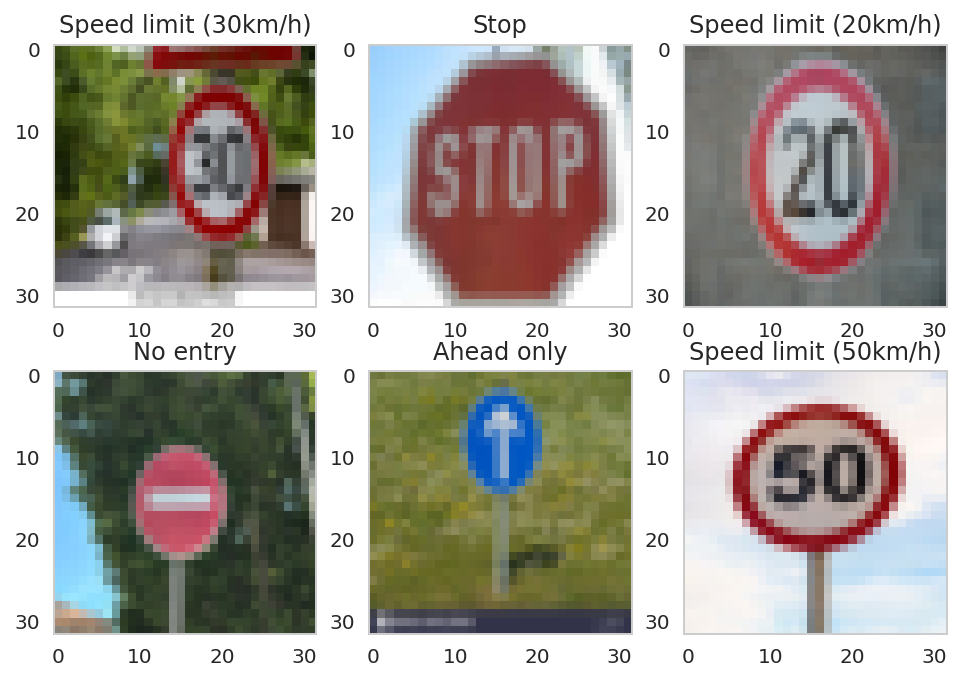

In [17]:
ax = plt.subplot(2,3,1)
ax.set_title(signnamesDF[signnamesDF['ClassId'] ==1]['SignName'][1])
ax.grid(False)
ax.imshow(test_imgs[0])
ax2 = plt.subplot(2,3,2)
ax2.grid(False)
ax2.set_title(signnamesDF[signnamesDF['ClassId'] == 14]['SignName'][14])
ax2.imshow(test_imgs[1])
ax3 = plt.subplot(2,3,3)
ax3.grid(False)
ax3.set_title(signnamesDF[signnamesDF['ClassId'] == 0]['SignName'][0])
ax3.imshow(test_imgs[2])

ax4 = plt.subplot(2,3,4)
ax4.set_title(signnamesDF[signnamesDF['ClassId'] == 17]['SignName'][17])
ax4.grid(False)
ax4.imshow(test_imgs[3])
ax5 = plt.subplot(2,3,5)
ax5.grid(False)
ax5.set_title(signnamesDF[signnamesDF['ClassId'] == 35]['SignName'][35])
ax5.imshow(test_imgs[4])
ax6 = plt.subplot(2,3,6)
ax6.grid(False)
ax6.set_title(signnamesDF[signnamesDF['ClassId'] == 2]['SignName'][2])
ax6.imshow(test_imgs[5])

plt.savefig('examples/test_images.jpg')

In [51]:
vggLikePredict = vgglike.predict(normalize(test_imgs_arr))

In [54]:
classesPred = []
for i in range(len(vggLikePredict)):
    print(i, np.argmax(vggLikePredict[i]))
    classesPred.append(np.argmax(vggLikePredict[i]))
print(classesPred)

# actual classes are ([1,14,0, 17,35])

0 25
1 14
2 0
3 15
4 36
[25, 14, 0, 15, 36]


### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
accuracy = 0.4 
# hmm, not very good... 

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [61]:
top_probas = []
for i in range(len(vggLikePredict)):
    sorted_arr = np.sort(vggLikePredict[i])[::-1]
    sorted_indexes = np.argsort(vggLikePredict[i])[::-1]
    top_probas.append((sorted_indexes[::-1][:5], sorted_arr[:5]))

In [62]:
top_probas

[(array([17, 32,  0, 39, 14]),
  array([ 0.98943138,  0.00315887,  0.00190572,  0.00126036,  0.0010737 ], dtype=float32)),
 (array([ 6, 24, 19, 32, 39]),
  array([  9.99993443e-01,   5.67735424e-06,   2.01609353e-07,
           1.83130979e-07,   1.28657788e-07], dtype=float32)),
 (array([36, 30, 20, 27, 21]),
  array([  1.00000000e+00,   1.86118780e-13,   9.58082965e-14,
           5.22367971e-15,   2.77476199e-15], dtype=float32)),
 (array([37, 21, 31, 24,  7]),
  array([ 0.85467714,  0.0535549 ,  0.03745114,  0.02497163,  0.01915162], dtype=float32)),
 (array([ 7,  0, 16,  6, 31]),
  array([ 0.98891592,  0.00451771,  0.00348161,  0.00162086,  0.0014565 ], dtype=float32))]

In [56]:
np.argsort(vggLikePredict[0])[::-1]

array([25, 11, 24, 30, 40, 12,  2,  1, 23,  7, 31,  5, 38,  9, 13, 34, 15,
       18, 35,  3, 42, 26, 21, 37, 33,  4, 28, 27,  8, 22, 29, 36, 20, 16,
       10, 19, 41,  6, 14, 39,  0, 32, 17])

In [50]:
np.argmax(vggLikePredict[0])

0

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")